In [14]:
library(MASS)
library(tidyverse)
library(knitr)
library(dplyr)
library(ggplot2)
library(glmnet)
library(caret)

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-8

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift




In [46]:
#dat = read.csv("data.csv")
url="https://raw.githubusercontent.com/DrTaibaipiao/Placement-Prediction-Dataset/refs/heads/main/data.csv"
dat = read.csv(url)

summary(dat)

   StudentID          CGPA        Internships       Projects    
 Min.   :    1   Min.   :6.500   Min.   :0.000   Min.   :0.000  
 1st Qu.: 2501   1st Qu.:7.400   1st Qu.:1.000   1st Qu.:1.000  
 Median : 5000   Median :7.700   Median :1.000   Median :2.000  
 Mean   : 5000   Mean   :7.698   Mean   :1.049   Mean   :2.027  
 3rd Qu.: 7500   3rd Qu.:8.200   3rd Qu.:1.000   3rd Qu.:3.000  
 Max.   :10000   Max.   :9.100   Max.   :2.000   Max.   :3.000  
 Workshops.Certifications AptitudeTestScore SoftSkillsRating
 Min.   :0.000            Min.   :60.00     Min.   :3.000   
 1st Qu.:0.000            1st Qu.:73.00     1st Qu.:4.000   
 Median :1.000            Median :80.00     Median :4.400   
 Mean   :1.013            Mean   :79.45     Mean   :4.324   
 3rd Qu.:2.000            3rd Qu.:87.00     3rd Qu.:4.700   
 Max.   :3.000            Max.   :90.00     Max.   :4.800   
 ExtracurricularActivities PlacementTraining    SSC_Marks       HSC_Marks   
 Length:10000              Length:10000  

In [20]:
colSums(is.na(dat))

StudentID                      CGPA               Internships 
                        0                         0                         0 
                 Projects  Workshops.Certifications         AptitudeTestScore 
                        0                         0                         0 
         SoftSkillsRating ExtracurricularActivities         PlacementTraining 
                        0                         0                         0 
                SSC_Marks                 HSC_Marks           PlacementStatus 
                        0                         0                         0

The dataset contains academic, training, and placement-related information about 10000 students on 12 different aspects. There are no missing values, and the target variable is PlacementStatus, indicating whether a student was placed. The data is originally from https://www.kaggle.com/datasets/ruchikakumbhar/placement-prediction-dataset?resource=download

In [21]:
chart_1q= data.frame(
"Variable name"=names(dat),
  "Type"=c("Categorical","Numeric","Numeric","Numeric","Numeric","Numeric","Numeric","Binary","Binary","Numeric","Numeric","Binary")
    )
chart_1q

Variable.name,Type
<chr>,<chr>
StudentID,Categorical
CGPA,Numeric
Internships,Numeric
Projects,Numeric
Workshops.Certifications,Numeric
AptitudeTestScore,Numeric
SoftSkillsRating,Numeric
ExtracurricularActivities,Binary
PlacementTraining,Binary


In [22]:
dat = dat[, !names(dat) %in% "StudentID"] 
dat = dat %>% mutate(
  PlacementTraining = ifelse(PlacementTraining == "Yes", 1, 0),
  ExtracurricularActivities = ifelse(ExtracurricularActivities == "Yes", 1, 0)
)
dat$PlacementStatus = as.factor(dat$PlacementStatus)
names(dat) #This is intended to show what variables do we keep, i.e, getting rid off student ID, which is not meaningful. 

[1] "CGPA"                      "Internships"              
 [3] "Projects"                  "Workshops.Certifications" 
 [5] "AptitudeTestScore"         "SoftSkillsRating"         
 [7] "ExtracurricularActivities" "PlacementTraining"        
 [9] "SSC_Marks"                 "HSC_Marks"                
[11] "PlacementStatus"

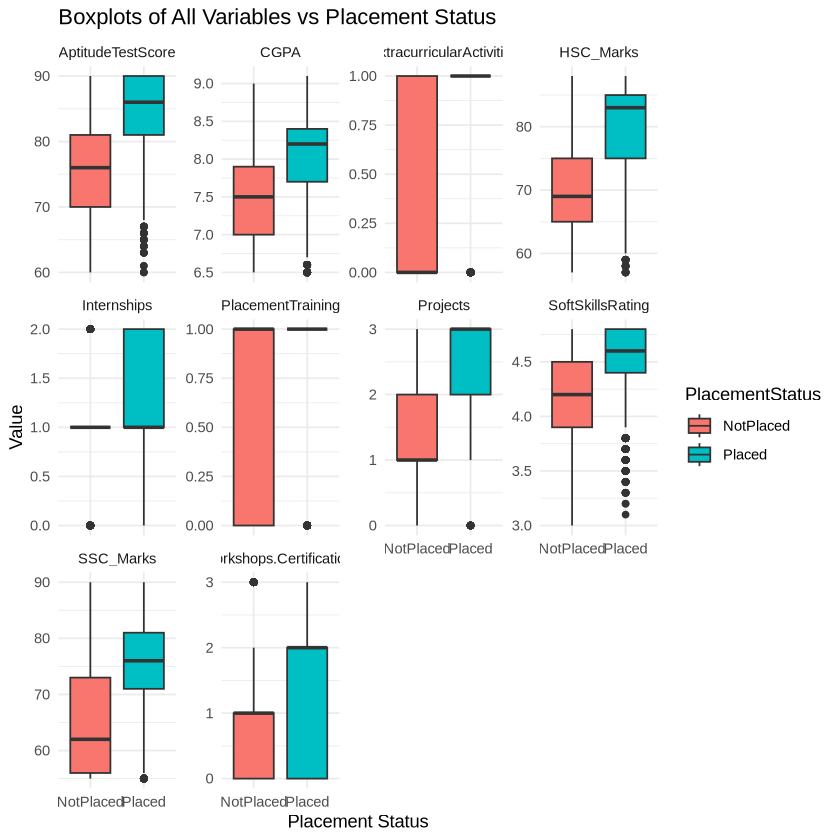

In [23]:
dat_long = dat %>%pivot_longer(cols = -PlacementStatus, names_to = "Variable", values_to = "Value")

ggplot(dat_long, aes(x = PlacementStatus, y = Value, fill = PlacementStatus)) +
  geom_boxplot() + 
  facet_wrap(~Variable, scales = "free_y") + 
  theme_minimal() +
  labs(title = "Boxplots of All Variables vs Placement Status",
       x = "Placement Status",
       y = "Value") 

Assignment 2:

I am switching my goal to building a prediction model. Specifically, I aim to predict the probability that a student will be placed after graduation, using the available variables, while avoiding potential overfitting.

I propose using logistic regression with Lasso regularization. This method is appropriate because the response variable, PlacementStatus, is binary. Lasso improves standard logistic regression by shrinking less relevant coefficients and removing unimportant features from the model. I will use cross-validation to select the optimal level of regularization, helping ensure a model that generalizes well without overfitting.

To use this method, we assume that observations are independent, no perfect multicollinearity between predictors, and linearity in the log-odds.

A limitation of this approach is that Lasso may exclude predictors that are weak but still meaningful when combined with others. In other words, variables with small but true effects might be ignored by the penalty, potentially limiting interpretability or explanatory power.

In [41]:
# Prepare feature matrix
x = model.matrix(PlacementStatus ~ ., data = dat)[, -1]
# Create binary response variable: 1 for Placed, 0 for NotPlaced
y = ifelse(dat$PlacementStatus == "Placed", 1, 0)

# Use 10-fold cross-validation to find the best regularization strength (lambda)
cv_fit = cv.glmnet(x, y, alpha = 1, family = "binomial", nfolds = 10)
# Extract the best lambda value
best_lambda = cv_fit$lambda.min
# Fit the final Lasso-regularized logistic regression model
final_model = glmnet(x, y, alpha = 1, family = "binomial", lambda = best_lambda)

# Extract and display model coefficients
coef_table = coef(final_model)

#Clean up and show the result
result = as.data.frame(as.matrix(coef_table))
colnames(result) = "Coefficient"
result = result[order(result$Coefficient, decreasing = TRUE), , drop = FALSE]
print(result)

                           Coefficient
PlacementTraining           0.89676811
ExtracurricularActivities   0.73821526
SoftSkillsRating            0.65039894
CGPA                        0.37902087
Projects                    0.25789909
Workshops.Certifications    0.13891486
AptitudeTestScore           0.06960026
SSC_Marks                   0.02806358
HSC_Marks                   0.02753385
Internships                 0.00000000
(Intercept)               -17.61845687


The Lasso logistic regression model retained all predictors except Internships, assigning non-zero coefficients to all others. "PlacementTraining", "ExtracurricularActivities", and "SoftSkillsRating" have the top 3 largest positive effects on the probability of being placed, suggesting that training, engagement beyond academics, and soft skills are strong predictors for the student's future placement. The results are consistent with expectations and indicate that a well-rounded student profile contributes to placement success. These findings could help students prioritize efforts in areas such as training, communication, and campus involvement to improve their employment prospects.